# Data

In [ ]:
pip install pandas scikit-learn xgboost matplotlib

In [231]:
import pandas as pd

shot_events_path = 'Data/S21.xlsx'
playerid_path = 'Data/P21.xlsx'
coordinates_path = 'Data/C21.xlsx'

shot_events = pd.read_excel(shot_events_path)
playerid = pd.read_excel(playerid_path)
coordinates = pd.read_excel(coordinates_path)

shot_events.head(), playerid.head(), coordinates.head()

d = 27

In [232]:
shots_data = shot_events[['timestamp', 'player_id','is_succeeded']].copy()

player_data = playerid[['playerId', 'Match Team']]  
player_team_map = dict(zip(player_data['playerId'], player_data['Match Team']))  

coordinates_data = coordinates.copy()
coordinates_data['timestamp'] = pd.to_datetime(coordinates_data['timestamp'])  
shots_data['timestamp'] = pd.to_datetime(shots_data['timestamp'], unit='ms')  

matched_coordinates = coordinates_data[coordinates_data['timestamp'].isin(shots_data['timestamp'])].copy()

for i in range(d):
    player_col = f'playerId{i}'  
    matchteam_col = f'MatchTeam{i}'  
    matched_coordinates[matchteam_col] = matched_coordinates[player_col].map(player_team_map) 

final_data = shots_data.merge(matched_coordinates, on='timestamp', how='left')

columns_to_keep = ['timestamp', 'player_id', 'is_succeeded']
for i in range(d):
    columns_to_keep.extend([f'playerId{i}', f'MatchTeam{i}', f'posX{i}', f'posY{i}'])

final_data = final_data[columns_to_keep]

player_team_map = dict(zip(playerid['playerId'], playerid['Match Team']))

final_data['MatchTeam'] = final_data['player_id'].map(player_team_map)

#for col, value in final_data.iloc[0].items():
#    print(f"{col}: {value}")
final_data.head(10)

,timestamp,player_id,is_succeeded,playerId0,MatchTeam0,posX0,posY0,playerId1,MatchTeam1,posX1,...,posY24,playerId25,MatchTeam25,posX25,posY25,playerId26,MatchTeam26,posX26,posY26,MatchTeam
0,2022-05-09 16:02:11.200,95450,False,95497,USV Hercules Jong 2.1,-100,-100,95298,USV Hercules Jong 2.1,-100,...,30,95436,USV Hercules Jong 2.1,35,17,95440,USV Hercules Jong 2.1,16,17,USV Hercules Jong 2.1
1,2022-05-09 16:03:48.000,95454,False,95497,USV Hercules Jong 2.1,-100,-100,95298,USV Hercules Jong 2.1,-100,...,40,95436,USV Hercules Jong 2.1,66,23,95440,USV Hercules Jong 2.1,58,26,USV Hercules Jong 1
2,2022-05-09 16:11:15.000,95459,False,95497,USV Hercules Jong 2.1,-100,-100,95298,USV Hercules Jong 2.1,-100,...,31,95436,USV Hercules Jong 2.1,15,9,95440,USV Hercules Jong 2.1,27,26,USV Hercules Jong 2.1
3,2022-05-09 16:14:43.400,95450,False,95497,USV Hercules Jong 2.1,-100,-100,95298,USV Hercules Jong 2.1,-100,...,29,95436,USV Hercules Jong 2.1,26,12,95440,USV Hercules Jong 2.1,13,19,USV Hercules Jong 2.1
4,2022-05-09 16:14:46.200,95459,True,95497,USV Hercules Jong 2.1,-100,-100,95298,USV Hercules Jong 2.1,-100,...,28,95436,USV Hercules Jong 2.1,26,15,95440,USV Hercules Jong 2.1,13,20,USV Hercules Jong 2.1
5,2022-05-09 16:20:50.000,95460,True,95497,USV Hercules Jong 2.1,62,44,95298,USV Hercules Jong 2.1,75,...,50,95436,USV Hercules Jong 2.1,86,25,95440,USV Hercules Jong 2.1,67,33,USV Hercules Jong 1
6,2022-05-09 16:21:40.600,95457,False,95497,USV Hercules Jong 2.1,36,44,95298,USV Hercules Jong 2.1,51,...,40,95436,USV Hercules Jong 2.1,44,10,95440,USV Hercules Jong 2.1,33,32,USV Hercules Jong 2.1
7,2022-05-09 16:22:09.800,95459,False,95497,USV Hercules Jong 2.1,7,33,95298,USV Hercules Jong 2.1,4,...,30,95436,USV Hercules Jong 2.1,39,31,95440,USV Hercules Jong 2.1,15,32,USV Hercules Jong 2.1
8,2022-05-09 16:23:48.800,95459,True,95497,USV Hercules Jong 2.1,47,35,95298,USV Hercules Jong 2.1,58,...,41,95436,USV Hercules Jong 2.1,52,18,95440,USV Hercules Jong 2.1,37,27,USV Hercules Jong 2.1
9,2022-05-09 16:29:51.800,95454,False,95497,USV Hercules Jong 2.1,76,32,95298,USV Hercules Jong 2.1,88,...,44,95436,USV Hercules Jong 2.1,-100,-100,95440,USV Hercules Jong 2.1,71,28,USV Hercules Jong 1


In [233]:
coordinates_data['timestamp'] = coordinates_data['timestamp'].dt.floor('S')  
shots_data['timestamp'] = shots_data['timestamp'].dt.floor('S')  
coordinates_data = coordinates_data.sort_values(by='timestamp')

coordinates_data = coordinates_data.drop_duplicates(subset=['timestamp'])

for i in range(d): 
    player_col = f'playerId{i}'
    matchteam_col = f'MatchTeam{i}'
    if player_col in coordinates_data.columns:
        coordinates_data[matchteam_col] = coordinates_data[player_col].map(player_team_map)

extended_data = []

for _, shot in shots_data.iterrows():
    shot_time = shot['timestamp']
    
    previous_timestamps = [shot_time - pd.Timedelta(seconds=i) for i in range(1, 6)]
    
    previous_rows = coordinates_data[coordinates_data['timestamp'].isin(previous_timestamps)]
    
    for _, row in previous_rows.iterrows():
        row_data = row.copy()
        row_data['is_succeeded'] = shot['is_succeeded']
        row_data['player_id'] = shot['player_id']
        row_data['MatchTeam'] = player_team_map.get(shot['player_id'], None)
        extended_data.append(row_data)
    
    shot_row = coordinates_data[coordinates_data['timestamp'] == shot_time].iloc[0].copy()
    shot_row['is_succeeded'] = shot['is_succeeded']
    shot_row['player_id'] = shot['player_id']
    shot_row['MatchTeam'] = player_team_map.get(shot['player_id'], None)
    extended_data.append(shot_row)

final_extended_data = pd.DataFrame(extended_data)

for i in range(d): 
    player_col = f'playerId{i}'
    matchteam_col = f'MatchTeam{i}'
    if player_col in final_extended_data.columns:
        final_extended_data[matchteam_col] = final_extended_data[player_col].map(player_team_map)

if 'Unnamed: 0' in final_extended_data.columns:
    final_extended_data = final_extended_data.drop(columns=['Unnamed: 0'])

final_extended_data
#for col, value in final_extended_data.iloc[0].items():
#    print(f"{col}: {value}")

C:\Users\Daan-\AppData\Local\Temp\ipykernel_19672\546542596.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  coordinates_data['timestamp'] = coordinates_data['timestamp'].dt.floor('S')
C:\Users\Daan-\AppData\Local\Temp\ipykernel_19672\546542596.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  shots_data['timestamp'] = shots_data['timestamp'].dt.floor('S')


,timestamp,ballId,ballposX,ballposY,playerId0,posX0,posY0,playerId1,posX1,posY1,...,MatchTeam20,MatchTeam21,MatchTeam22,MatchTeam23,MatchTeam24,MatchTeam25,MatchTeam26,is_succeeded,player_id,MatchTeam
877,2022-05-09 16:02:06,2942,5,2,95497,-100,-100,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,False,95450,USV Hercules Jong 2.1
886,2022-05-09 16:02:07,2942,8,5,95497,-100,-100,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,False,95450,USV Hercules Jong 2.1
887,2022-05-09 16:02:08,2942,8,5,95497,-100,-100,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,False,95450,USV Hercules Jong 2.1
896,2022-05-09 16:02:09,2942,5,11,95497,-100,-100,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,False,95450,USV Hercules Jong 2.1
897,2022-05-09 16:02:10,2942,5,11,95497,-100,-100,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,False,95450,USV Hercules Jong 2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22371,2022-05-09 17:13:57,3011,69,13,95497,50,12,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,True,95460,USV Hercules Jong 1
22379,2022-05-09 17:13:58,3011,68,13,95497,49,12,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,True,95460,USV Hercules Jong 1
22381,2022-05-09 17:13:59,3011,69,14,95497,49,13,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,True,95460,USV Hercules Jong 1
22386,2022-05-09 17:14:00,3011,71,18,95497,49,12,95298,-100,-100,...,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,USV Hercules Jong 2.1,True,95460,USV Hercules Jong 1


In [234]:
columns = ['ballx', 'bally', 'is_succeeded'] + [f'oppx{i}' for i in range(1, 12)] + [f'oppy{i}' for i in range(1, 12)]

temp_df = pd.DataFrame(0, index=range(len(final_extended_data)), columns=columns) 

temp_df

,ballx,bally,is_succeeded,oppx1,oppx2,oppx3,oppx4,oppx5,oppx6,oppx7,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [235]:
final_extended_data = final_extended_data.reset_index(drop=True)

temp_df['ballx'] = final_extended_data['ballposX']
temp_df['bally'] = final_extended_data['ballposY']
temp_df['is_succeeded'] = final_extended_data['is_succeeded']

for idx, row in final_extended_data.iterrows():
    shooting_team = row['MatchTeam']
    opponent_coords = []

    for i in range(d):
        team_col = f'MatchTeam{i}'
        x_col = f'posX{i}'
        y_col = f'posY{i}'

        if row[team_col] != shooting_team and (row[x_col], row[y_col]) != (-100, -100):
            opponent_coords.append((row[x_col], row[y_col]))

    opponent_coords = opponent_coords[:11]

    for j, (x, y) in enumerate(opponent_coords):
        temp_df.loc[idx, f'oppx{j+1}'] = x
        temp_df.loc[idx, f'oppy{j+1}'] = y

empty_df = pd.concat([empty_df, temp_df], ignore_index=True)
empty_df

,ballx,bally,is_succeeded,oppx1,oppx2,oppx3,oppx4,oppx5,oppx6,oppx7,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,90,23,False,74,75,59,67,92,89,95,...,19,51,39,22,40,26,9,28,4,0
1,82,26,False,75,75,59,68,93,91,96,...,19,50,37,25,36,28,10,27,5,0
2,89,27,False,77,76,60,69,91,91,96,...,20,50,37,26,34,29,12,27,5,0
3,104,32,False,78,77,60,70,90,93,98,...,21,51,37,26,35,30,14,27,6,0
4,104,31,False,78,77,60,70,90,93,99,...,21,51,37,26,35,30,14,27,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,69,13,True,50,63,49,59,53,88,54,...,49,47,6,26,28,21,16,13,41,36
3506,68,13,True,49,62,47,57,54,88,56,...,48,46,5,25,29,19,16,13,39,36
3507,69,14,True,49,62,47,58,54,88,57,...,48,45,5,24,29,19,16,14,38,35
3508,71,18,True,49,62,47,58,56,90,57,...,48,45,4,24,29,19,18,15,35,35


In [236]:
empty_df.to_csv('empty_df.csv', index=False)

In [110]:
columns = ['ballx', 'bally', 'is_succeeded'] + [f'oppx{i}' for i in range(1, 12)] + [f'oppy{i}' for i in range(1, 12)]

empty_df = pd.DataFrame(0, index=range(len(final_extended_data)), columns=columns) 

empty_df

,ballx,bally,is_succeeded,oppx1,oppx2,oppx3,oppx4,oppx5,oppx6,oppx7,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
final_extended_data = final_extended_data.reset_index(drop=True)

empty_df['ballx'] = final_extended_data['ballposX']
empty_df['bally'] = final_extended_data['ballposY']
empty_df['is_succeeded'] = final_extended_data['is_succeeded']

for idx, row in final_extended_data.iterrows():
    shooting_team = row['MatchTeam']
    opponent_coords = []

    for i in range(d): 
        team_col = f'MatchTeam{i}'
        x_col = f'posX{i}'
        y_col = f'posY{i}'

        if row[team_col] != shooting_team and (row[x_col], row[y_col]) != (-100, -100):
            opponent_coords.append((row[x_col], row[y_col]))

    opponent_coords = opponent_coords[:11]

    for j, (x, y) in enumerate(opponent_coords):
        empty_df.loc[idx, f'oppx{j+1}'] = x
        empty_df.loc[idx, f'oppy{j+1}'] = y

empty_df

,ballx,bally,is_succeeded,oppx1,oppx2,oppx3,oppx4,oppx5,oppx6,oppx7,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,90,23,False,74,75,59,67,92,89,95,...,19,51,39,22,40,26,9,28,4,0
1,82,26,False,75,75,59,68,93,91,96,...,19,50,37,25,36,28,10,27,5,0
2,89,27,False,77,76,60,69,91,91,96,...,20,50,37,26,34,29,12,27,5,0
3,104,32,False,78,77,60,70,90,93,98,...,21,51,37,26,35,30,14,27,6,0
4,104,31,False,78,77,60,70,90,93,99,...,21,51,37,26,35,30,14,27,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,93,30,False,79,71,58,88,84,58,98,...,17,53,25,5,25,32,26,31,38,6
164,99,22,False,82,73,60,88,85,59,98,...,19,54,27,6,27,31,30,30,34,7
165,99,21,False,83,73,61,89,85,60,98,...,20,54,27,7,27,31,29,29,34,8
166,98,23,False,86,75,63,94,87,61,96,...,21,54,26,9,28,30,28,27,31,8


# HERE

In [143]:
import pandas as pd

base_data = pd.read_csv('empty_df.csv')
base_data.loc[base_data['ballx'] >= 100, 'ballx'] = 100
base_data.loc[base_data['ballx'] <= 0, 'ballx'] = 0
base_data

,ballx,bally,is_succeeded,oppx1,oppx2,oppx3,oppx4,oppx5,oppx6,oppx7,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,90,23,False,74,75,59,67,92,89,95,...,19,51,39,22,40,26,9,28,4,0
1,82,26,False,75,75,59,68,93,91,96,...,19,50,37,25,36,28,10,27,5,0
2,89,27,False,77,76,60,69,91,91,96,...,20,50,37,26,34,29,12,27,5,0
3,100,32,False,78,77,60,70,90,93,98,...,21,51,37,26,35,30,14,27,6,0
4,100,31,False,78,77,60,70,90,93,99,...,21,51,37,26,35,30,14,27,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,69,13,True,50,63,49,59,53,88,54,...,49,47,6,26,28,21,16,13,41,36
3506,68,13,True,49,62,47,57,54,88,56,...,48,46,5,25,29,19,16,13,39,36
3507,69,14,True,49,62,47,58,54,88,57,...,48,45,5,24,29,19,16,14,38,35
3508,71,18,True,49,62,47,58,56,90,57,...,48,45,4,24,29,19,18,15,35,35


In [144]:
#base_data['ballx'] = base_data['ballx'].apply(lambda x: 100-x if x > 50 else x)
base_data['is_succeeded'] = base_data['is_succeeded'].apply(lambda x: 1 if x == True else 0)

print(base_data)

      ballx  bally  is_succeeded  oppx1  oppx2  oppx3  oppx4  oppx5  oppx6  \
0        90     23             0     74     75     59     67     92     89   
1        82     26             0     75     75     59     68     93     91   
2        89     27             0     77     76     60     69     91     91   
3       100     32             0     78     77     60     70     90     93   
4       100     31             0     78     77     60     70     90     93   
...     ...    ...           ...    ...    ...    ...    ...    ...    ...   
3505     69     13             1     50     63     49     59     53     88   
3506     68     13             1     49     62     47     57     54     88   
3507     69     14             1     49     62     47     58     54     88   
3508     71     18             1     49     62     47     58     56     90   
3509     86     28             1     50     64     48     60     61     91   

      oppx7  ...  oppy2  oppy3  oppy4  oppy5  oppy6  oppy7  opp

In [145]:
data = {
    'shot_x': base_data['ballx'],  
    'shot_y': base_data['bally'],
    'goal': base_data['is_succeeded'],
    'oppx1': base_data['oppx1'],  
    'oppx2': base_data['oppx2'],  
    'oppx3': base_data['oppx3'],  
    'oppx4': base_data['oppx4'],  
    'oppx5': base_data['oppx5'],  
    'oppx6': base_data['oppx6'],  
    'oppx7': base_data['oppx7'],  
    'oppx8': base_data['oppx8'],  
    'oppx9': base_data['oppx9'],  
    'oppx10': base_data['oppx10'],  
    'oppx11': base_data['oppx11'],  
    'oppy1': base_data['oppy1'],
    'oppy2': base_data['oppy2'],
    'oppy3': base_data['oppy3'],
    'oppy4': base_data['oppy4'],
    'oppy5': base_data['oppy5'],
    'oppy6': base_data['oppy6'],
    'oppy7': base_data['oppy7'],
    'oppy8': base_data['oppy8'],
    'oppy9': base_data['oppy9'],
    'oppy10': base_data['oppy10'],
    'oppy11': base_data['oppy11'],
}
df = pd.DataFrame(data)
df

,shot_x,shot_y,goal,oppx1,oppx2,oppx3,oppx4,oppx5,oppx6,oppx7,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,90,23,0,74,75,59,67,92,89,95,...,19,51,39,22,40,26,9,28,4,0
1,82,26,0,75,75,59,68,93,91,96,...,19,50,37,25,36,28,10,27,5,0
2,89,27,0,77,76,60,69,91,91,96,...,20,50,37,26,34,29,12,27,5,0
3,100,32,0,78,77,60,70,90,93,98,...,21,51,37,26,35,30,14,27,6,0
4,100,31,0,78,77,60,70,90,93,99,...,21,51,37,26,35,30,14,27,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,69,13,1,50,63,49,59,53,88,54,...,49,47,6,26,28,21,16,13,41,36
3506,68,13,1,49,62,47,57,54,88,56,...,48,46,5,25,29,19,16,13,39,36
3507,69,14,1,49,62,47,58,54,88,57,...,48,45,5,24,29,19,16,14,38,35
3508,71,18,1,49,62,47,58,56,90,57,...,48,45,4,24,29,19,18,15,35,35


In [146]:
import numpy as np

goal_y = 31.5
goal_x = np.where(df['shot_x'] < 50, 0, 100)
df['distance'] = np.sqrt((df['shot_x'] - goal_x)**2 + (df['shot_y'] - goal_y)**2)
df['dist_to_opponent1'] = np.sqrt((df['shot_x'] - df['oppx1'])**2 + (df['shot_y'] - df['oppy1'])**2)
df['dist_to_opponent2'] = np.sqrt((df['shot_x'] - df['oppx2'])**2 + (df['shot_y'] - df['oppy2'])**2)
df['dist_to_opponent3'] = np.sqrt((df['shot_x'] - df['oppx3'])**2 + (df['shot_y'] - df['oppy3'])**2)
df['dist_to_opponent4'] = np.sqrt((df['shot_x'] - df['oppx4'])**2 + (df['shot_y'] - df['oppy4'])**2)
df['dist_to_opponent5'] = np.sqrt((df['shot_x'] - df['oppx5'])**2 + (df['shot_y'] - df['oppy5'])**2)
df['dist_to_opponent6'] = np.sqrt((df['shot_x'] - df['oppx6'])**2 + (df['shot_y'] - df['oppy6'])**2)
df['dist_to_opponent7'] = np.sqrt((df['shot_x'] - df['oppx7'])**2 + (df['shot_y'] - df['oppy7'])**2)
df['dist_to_opponent8'] = np.sqrt((df['shot_x'] - df['oppx8'])**2 + (df['shot_y'] - df['oppy8'])**2)
df['dist_to_opponent9'] = np.sqrt((df['shot_x'] - df['oppx9'])**2 + (df['shot_y'] - df['oppy9'])**2)
df['dist_to_opponent10'] = np.sqrt((df['shot_x'] - df['oppx10'])**2 + (df['shot_y'] - df['oppy10'])**2)
df['dist_to_opponent11'] = np.sqrt((df['shot_x'] - df['oppx11'])**2 + (df['shot_y'] - df['oppy11'])**2)
df['angle'] = np.degrees(np.arctan2(df['shot_y'], df['shot_x'])) 
df['closest_opponent'] = df[['dist_to_opponent1', 'dist_to_opponent2', 'dist_to_opponent3', 'dist_to_opponent4', 'dist_to_opponent5', 'dist_to_opponent6', 'dist_to_opponent7', 'dist_to_opponent8', 'dist_to_opponent9', 'dist_to_opponent10', 'dist_to_opponent11']].min(axis=1)
df['average_opponent_distance'] = df[['dist_to_opponent1', 'dist_to_opponent2', 'dist_to_opponent3', 'dist_to_opponent4', 'dist_to_opponent5', 'dist_to_opponent6', 'dist_to_opponent7', 'dist_to_opponent8', 'dist_to_opponent9', 'dist_to_opponent10', 'dist_to_opponent11']].mean(axis=1)

print(df[['shot_x', 'shot_y', 'distance', 'angle', 'closest_opponent', 'average_opponent_distance']])

      shot_x  shot_y   distance      angle  closest_opponent  \
0         90      23  13.124405  14.335435          2.236068   
1         82      26  18.821530  17.592425          9.899495   
2         89      27  11.884864  16.876265          2.236068   
3        100      32   0.500000  17.744672          2.828427   
4        100      31   0.500000  17.223436          1.414214   
...      ...     ...        ...        ...               ...   
3505      69      13  36.100554  10.669783          1.000000   
3506      68      13  36.962819  10.823011          1.000000   
3507      69      14  35.598455  11.469530          1.000000   
3508      71      18  31.988279  14.225964          3.000000   
3509      86      28  14.430870  18.034286          5.385165   

      average_opponent_distance  
0                     29.399119  
1                     25.266046  
2                     26.315430  
3                     33.282478  
4                     33.082502  
...                        

In [147]:
angle_tolerance = 10

def calculate_angle(x1, y1, x2, y2):
    return np.degrees(np.arctan2(y2 - y1, x2 - x1))

opponent_columns = [f'oppx{i}' for i in range(1, 12)]
opponent_y_columns = [f'oppy{i}' for i in range(1, 12)]

for i in range(1, 12):
    df[f'opponent{i}_angle'] = calculate_angle(
        df['shot_x'], df['shot_y'], df[f'oppx{i}'], df[f'oppy{i}']
    )

def count_opponents_in_trajectory(row, angle_tolerance):
    shot_angle = row['angle']
    count = 0
    for i in range(1, 12):
        opponent_angle = row[f'opponent{i}_angle']
        if abs(opponent_angle - shot_angle) <= angle_tolerance:
            count += 1
    return count

df['opponents_in_trajectory'] = df.apply(
    count_opponents_in_trajectory, axis=1, angle_tolerance=angle_tolerance
)

print(df[['shot_x', 'shot_y', 'distance', 'angle', 'closest_opponent', 'average_opponent_distance', 'opponents_in_trajectory']])

      shot_x  shot_y   distance      angle  closest_opponent  \
0         90      23  13.124405  14.335435          2.236068   
1         82      26  18.821530  17.592425          9.899495   
2         89      27  11.884864  16.876265          2.236068   
3        100      32   0.500000  17.744672          2.828427   
4        100      31   0.500000  17.223436          1.414214   
...      ...     ...        ...        ...               ...   
3505      69      13  36.100554  10.669783          1.000000   
3506      68      13  36.962819  10.823011          1.000000   
3507      69      14  35.598455  11.469530          1.000000   
3508      71      18  31.988279  14.225964          3.000000   
3509      86      28  14.430870  18.034286          5.385165   

      average_opponent_distance  opponents_in_trajectory  
0                     29.399119                        0  
1                     25.266046                        1  
2                     26.315430                       

In [148]:
columns_to_keep = ['shot_x', 'shot_y', 'goal', 'distance', 'angle',  
                   'average_opponent_distance', 'opponents_in_trajectory', 
                   'oppx1', 'oppx2', 'oppx3', 'oppx4', 'oppx5', 'oppx6', 'oppx7', 
                   'oppx8', 'oppx9', 'oppx10', 'oppx11', 'oppy1', 'oppy2', 'oppy3', 
                   'oppy4', 'oppy5', 'oppy6', 'oppy7', 'oppy8', 'oppy9', 'oppy10', 'oppy11']

df = df[columns_to_keep]

In [73]:
df.to_csv('test.csv', index=False)

In [74]:
df = pd.read_csv('test.csv')

In [149]:
df

,shot_x,shot_y,goal,distance,angle,average_opponent_distance,opponents_in_trajectory,oppx1,oppx2,oppx3,...,oppy2,oppy3,oppy4,oppy5,oppy6,oppy7,oppy8,oppy9,oppy10,oppy11
0,90,23,0,13.124405,14.335435,29.399119,0,74,75,59,...,19,51,39,22,40,26,9,28,4,0
1,82,26,0,18.821530,17.592425,25.266046,1,75,75,59,...,19,50,37,25,36,28,10,27,5,0
2,89,27,0,11.884864,16.876265,26.315430,1,77,76,60,...,20,50,37,26,34,29,12,27,5,0
3,100,32,0,0.500000,17.744672,33.282478,0,78,77,60,...,21,51,37,26,35,30,14,27,6,0
4,100,31,0,0.500000,17.223436,33.082502,0,78,77,60,...,21,51,37,26,35,30,14,27,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,69,13,1,36.100554,10.669783,21.615504,1,50,63,49,...,49,47,6,26,28,21,16,13,41,36
3506,68,13,1,36.962819,10.823011,20.879841,1,49,62,47,...,48,46,5,25,29,19,16,13,39,36
3507,69,14,1,35.598455,11.469530,20.208052,1,49,62,47,...,48,45,5,24,29,19,16,14,38,35
3508,71,18,1,31.988279,14.225964,19.190618,0,49,62,47,...,48,45,4,24,29,19,18,15,35,35


# FCL

In [142]:
X_fcl = X
y_fcl = y

In [249]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df[['shot_x', 'shot_y', 'distance', 'angle', 
        'average_opponent_distance', 'opponents_in_trajectory', 
        'oppx1', 'oppx2', 'oppx3', 'oppx4', 'oppx5', 'oppx6', 'oppx7', 
        'oppx8', 'oppx9', 'oppx10', 'oppx11', 'oppy1', 'oppy2', 'oppy3', 
        'oppy4', 'oppy5', 'oppy6', 'oppy7', 'oppy8', 'oppy9', 'oppy10', 'oppy11']]

y = df['goal']

X_train, X_test, y_train, y_test = train_test_split(X_fcl, y_fcl, test_size=0.2, random_state=42)

In [250]:
import tensorflow as tf
from tensorflow.keras import models, layers
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train= smote.fit_resample(X_train, y_train)

model = models.Sequential()

model.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Daan-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_107 (Dense)               │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [251]:
class_weights = {0: 1, 1: 5}

history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4775 - loss: 54.4768 - val_accuracy: 0.1897 - val_loss: 14.3443
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4834 - loss: 8.9734 - val_accuracy: 0.1897 - val_loss: 8.9237
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4811 - loss: 5.7822 - val_accuracy: 0.2069 - val_loss: 3.3432
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5148 - loss: 3.4597 - val_accuracy: 0.1983 - val_loss: 3.0091
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4981 - loss: 2.7437 - val_accuracy: 0.1897 - val_loss: 2.1240
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5252 - loss: 2.1436 - val_accuracy: 0.1983 - val_loss: 1.4425
Epoch 7/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5345 - loss: 1.8878 - val_accuracy: 0.1897 - val_loss: 1.4848
Epoch 8/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5121 - loss: 1.6826 - val_accuracy: 0.1897 - val_los

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Visualize the training process (loss and accuracy)
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from collections import Counter

y_prob = model.predict(X_test)  # y_prob contains probabilities from the sigmoid activation
y_pred = (y_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

class_counts = Counter(y_test)
total_samples = sum(class_counts.values())
imbalance_info = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Imbalance Statistics:")
print(pd.DataFrame.from_dict(imbalance_info, orient='index', columns=['Proportion']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'weighted' or 'macro' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

In [133]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")

ROC AUC: 0.6329787234042554
PR AUC: 0.4640804597701149


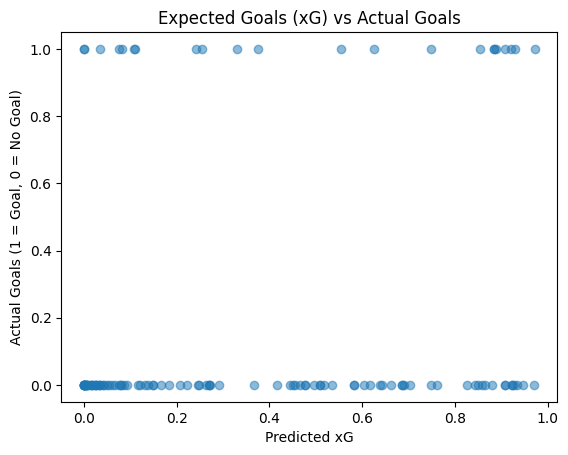

In [212]:
import matplotlib.pyplot as plt

plt.scatter(y_prob, y_test, alpha=0.5)
plt.xlabel("Predicted xG")
plt.ylabel("Actual Goals (1 = Goal, 0 = No Goal)")
plt.title("Expected Goals (xG) vs Actual Goals")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted XG values: [[0.92076236]]
True Label: 0


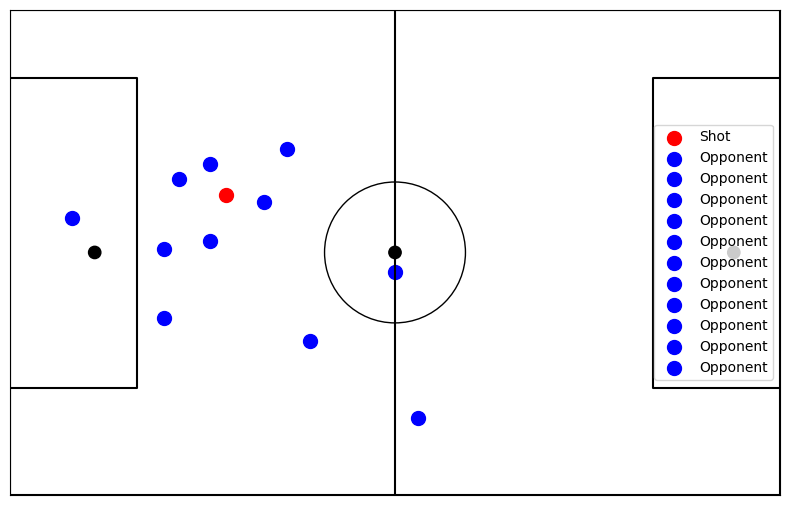

In [252]:
y_pred = model.predict(filled_data)

print(f"Predicted XG values: {y_pred}")
print(f"True Label: 0")

fig, ax = draw_pitch()

ax.scatter(filled_data['shot_x'], filled_data['shot_y'], color='red', label='Shot', s=100, marker='o')

for i in range(1, 12):
        ax.scatter(filled_data[f'oppx{i}'], filled_data[f'oppy{i}'], color='blue', label='Opponent', s=100, marker='o')

ax.set_xlim([0, 100])
ax.set_ylim([0, 63])

plt.legend()

plt.show()

# LSTM


In [255]:
!pip install imbalanced-learn

   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/258.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 4.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [232]:
import numpy as np

def transform_to_lstm_format(data, sequence_length=6, target_column="goal"):
    """
    Transforms the data into LSTM-ready format.
    
    Args:
        data (pd.DataFrame): Input data.
        sequence_length (int): Number of timesteps per sequence.
        target_column (str): Name of the column to use as the target.

    Returns:
        X (np.array): Features in LSTM-ready format (num_sequences, sequence_length, num_features).
        y (np.array): Targets corresponding to each sequence.
    """
    features = data.drop(columns=[target_column])
    targets = data[target_column].values

    num_sequences = len(data) // sequence_length

    X = np.array([
        features.iloc[i * sequence_length:(i + 1) * sequence_length].values
        for i in range(num_sequences)
    ])
    y = np.array([
        targets[(i + 1) * sequence_length - 1]  
        for i in range(num_sequences)
    ])

    return X, y

sequence_length = 6 
X, y = transform_to_lstm_format(df, sequence_length=sequence_length)

X.shape, y.shape, X[0], y[0]


((585, 6, 28),
 (585,),
 array([[ 90.        ,  23.        ,  13.12440475,  14.33543542,
          29.39911859,   0.        ,  74.        ,  75.        ,
          59.        ,  67.        ,  92.        ,  89.        ,
          95.        ,  76.        ,  65.        ,  58.        ,
           0.        ,  57.        ,  19.        ,  51.        ,
          39.        ,  22.        ,  40.        ,  26.        ,
           9.        ,  28.        ,   4.        ,   0.        ],
        [ 82.        ,  26.        ,  18.82153022,  17.59242456,
          25.2660459 ,   1.        ,  75.        ,  75.        ,
          59.        ,  68.        ,  93.        ,  91.        ,
          96.        ,  79.        ,  66.        ,  59.        ,
           0.        ,  54.        ,  19.        ,  50.        ,
          37.        ,  25.        ,  36.        ,  28.        ,
          10.        ,  27.        ,   5.        ,   0.        ],
        [ 89.        ,  27.        ,  11.88486432,  16.87626462,

In [242]:
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_samples, timesteps, n_features = X_train.shape
X_train = X_train.reshape(n_samples, timesteps * n_features)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = X_train.reshape(-1, timesteps, n_features)

model = models.Sequential()

model.add(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Daan-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 64)             │        23,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,033 (109.50 KB)

 Trainable params: 28,033 (109.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class_weights = {0: 1.0, 1: 5}  # Adjust class weights based on the imbalance ratio

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4750 - loss: 1.9535 - val_accuracy: 0.1880 - val_loss: 1.4377
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4857 - loss: 1.3256 - val_accuracy: 0.1880 - val_loss: 1.4381
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5082 - loss: 1.2441 - val_accuracy: 0.1880 - val_loss: 1.3261
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5093 - loss: 1.2281 - val_accuracy: 0.1880 - val_loss: 1.3814
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5447 - loss: 1.1751 - val_accuracy: 0.2308 - val_loss: 1.2338
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5441 - loss: 1.1286 - val_accuracy: 0.2564 - val_loss: 1.2383
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5828 - loss: 1.0947 - val_accuracy: 0.2564 - val_loss: 1.4244
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6049 - loss: 1.0712 - val_accuracy: 0.2991 - 

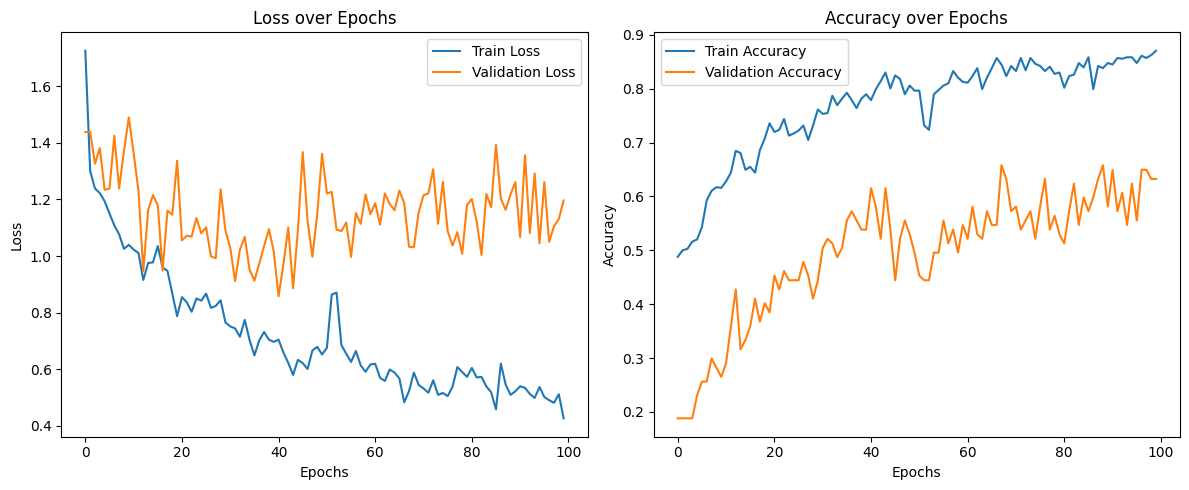

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Visualize the training process (loss and accuracy)
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Class Imbalance Statistics:
   Proportion
1    0.188034
0    0.811966

Confusion Matrix:
[[64 31]
 [12 10]]


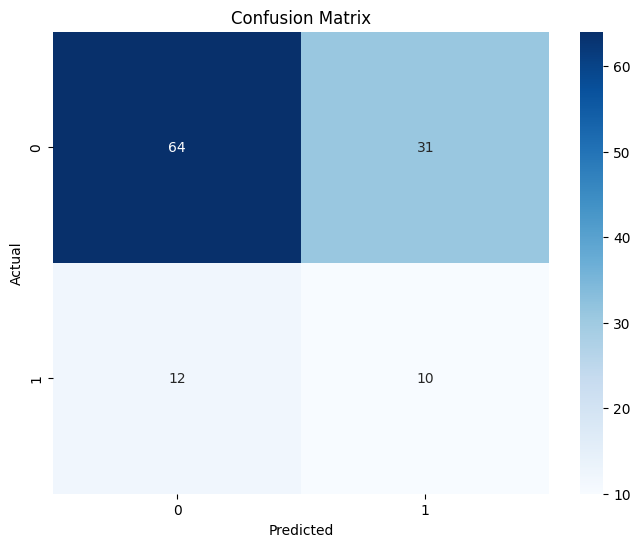


Evaluation Metrics:
Accuracy: 0.63
Precision: 0.24
Recall: 0.45
F1-Score: 0.32

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.67      0.75        95
           1       0.24      0.45      0.32        22

    accuracy                           0.63       117
   macro avg       0.54      0.56      0.53       117
weighted avg       0.73      0.63      0.67       117



In [244]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from collections import Counter

y_prob = model.predict(X_test)  # y_prob contains probabilities from the sigmoid activation
y_pred = (y_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

class_counts = Counter(y_test)
total_samples = sum(class_counts.values())
imbalance_info = {cls: count / total_samples for cls, count in class_counts.items()}
print("Class Imbalance Statistics:")
print(pd.DataFrame.from_dict(imbalance_info, orient='index', columns=['Proportion']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # Use 'weighted' or 'macro' for multiclass
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

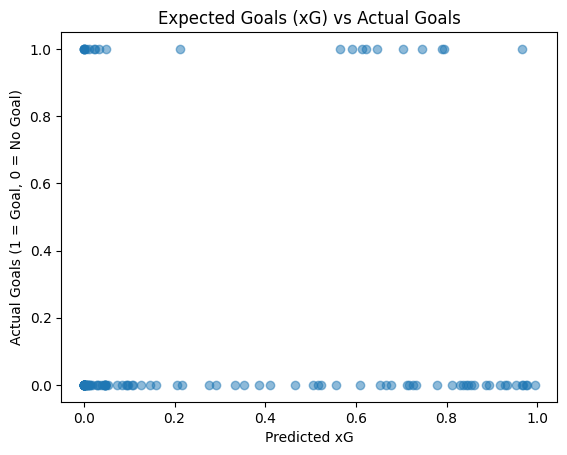

In [245]:
import matplotlib.pyplot as plt

plt.scatter(y_prob, y_test, alpha=0.5)
plt.xlabel("Predicted xG")
plt.ylabel("Actual Goals (1 = Goal, 0 = No Goal)")
plt.title("Expected Goals (xG) vs Actual Goals")
plt.show()

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.00030246]
100


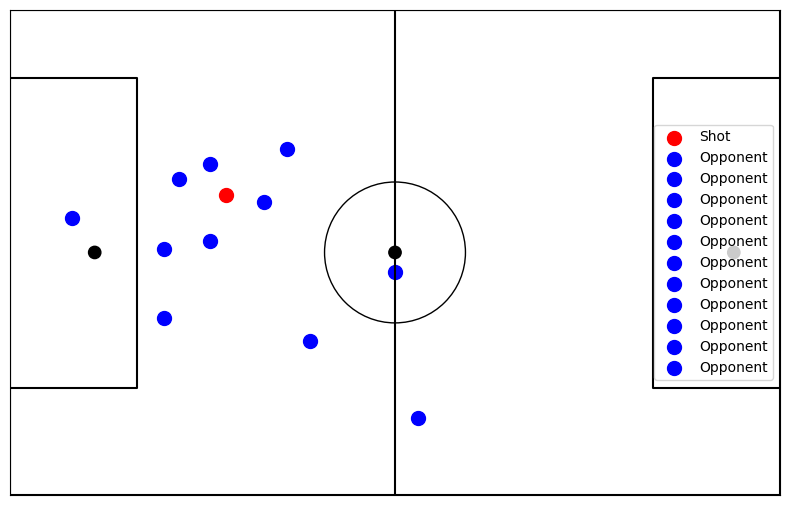

In [248]:
i = 100

print(f"True Label: {y_test[i]}")
print(f"Predicted Label: {y_pred[i]}")
last_sample = X_test[i][-1]  # This gets the last row in the 2D array
y_prob = model.predict(X_test)
print(y_prob[i])
print(i)

def draw_pitch():
    fig, ax = plt.subplots(figsize=(10, 6.3))
    
    plt.plot([0, 0, 100, 100, 0], [0, 63, 63, 0, 0], color="black")
    plt.plot([50, 50], [0, 63], color="black")
    plt.plot([0, 16.5, 16.5, 0], [13.84, 13.84, 54.16, 54.16], color="black")
    plt.plot([100, 83.5, 83.5, 100], [13.84, 13.84, 54.16, 54.16], color="black") 
    
    centre_circle = plt.Circle((50, 31.5), 9.15, color="black", fill=False)  # Center circle at x=50
    ax.add_patch(centre_circle)
    centre_spot = plt.Circle((50, 31.5), 0.8, color="black")
    ax.add_patch(centre_spot)

    left_pen_spot = plt.Circle((11, 31.5), 0.8, color="black")
    ax.add_patch(left_pen_spot)
    right_pen_spot = plt.Circle((94, 31.5), 0.8, color="black")
    ax.add_patch(right_pen_spot)
    
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 63)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    return fig, ax

labels = ['shot_x', 'shot_y', 'distance', 'angle',  
        'average_opponent_distance', 'opponents_in_trajectory', 
        'oppx1', 'oppx2', 'oppx3', 'oppx4', 'oppx5', 'oppx6', 'oppx7', 
        'oppx8', 'oppx9', 'oppx10', 'oppx11', 'oppy1', 'oppy2', 'oppy3', 
        'oppy4', 'oppy5', 'oppy6', 'oppy7', 'oppy8', 'oppy9', 'oppy10', 'oppy11']

# Create a pandas DataFrame
filled_data = pd.DataFrame([last_sample], columns=labels)

fig, ax = draw_pitch()

ax.scatter(filled_data['shot_x'], filled_data['shot_y'], color='red', label='Shot', s=100, marker='o')

for i in range(1, 12):
        ax.scatter(filled_data[f'oppx{i}'], filled_data[f'oppy{i}'], color='blue', label='Opponent', s=100, marker='o')

ax.set_xlim([0, 100])
ax.set_ylim([0, 63])

plt.legend()

plt.show()

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.00014089]
0


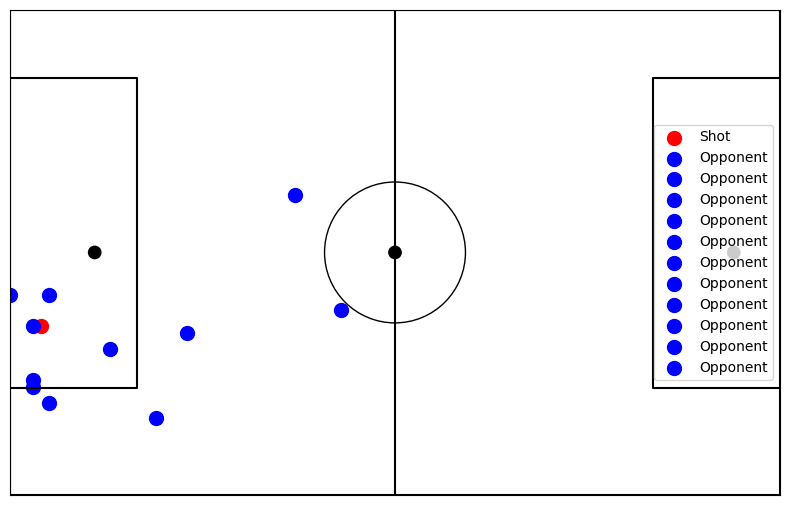

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.01076027]
27


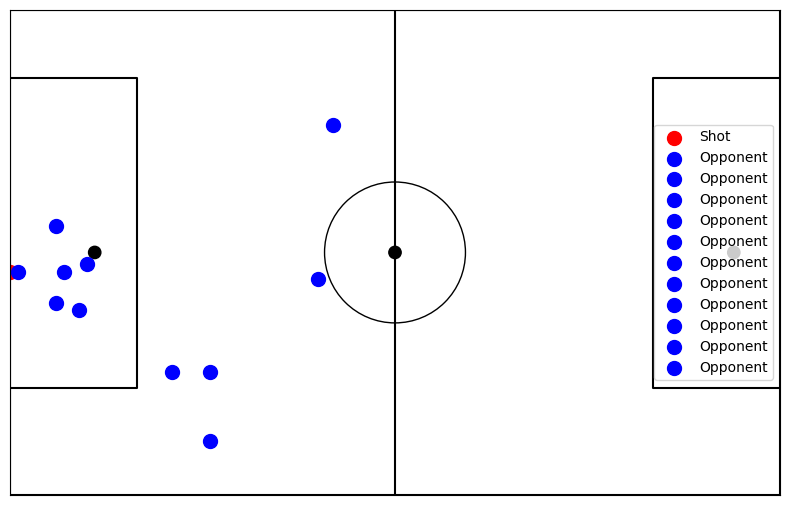

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.04906425]
28


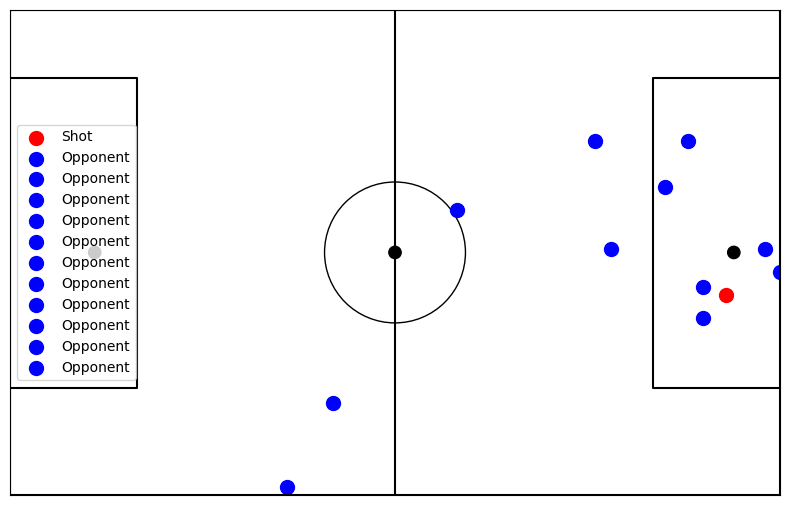

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.00379821]
40


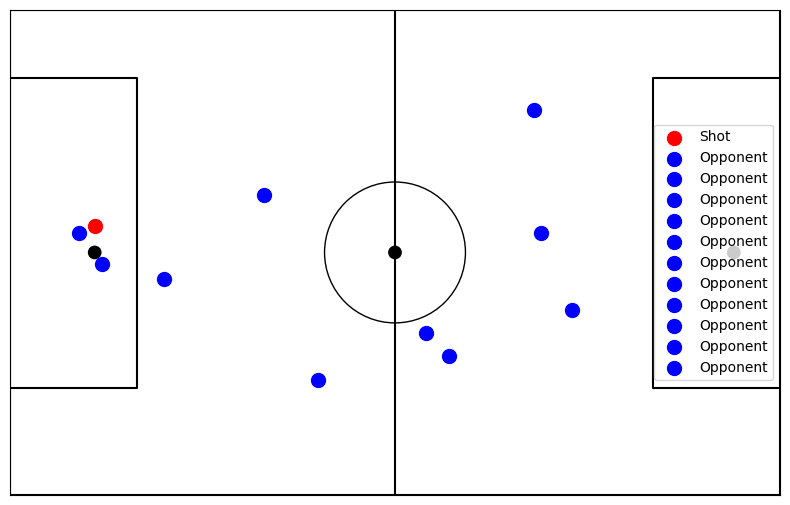

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.21214178]
58


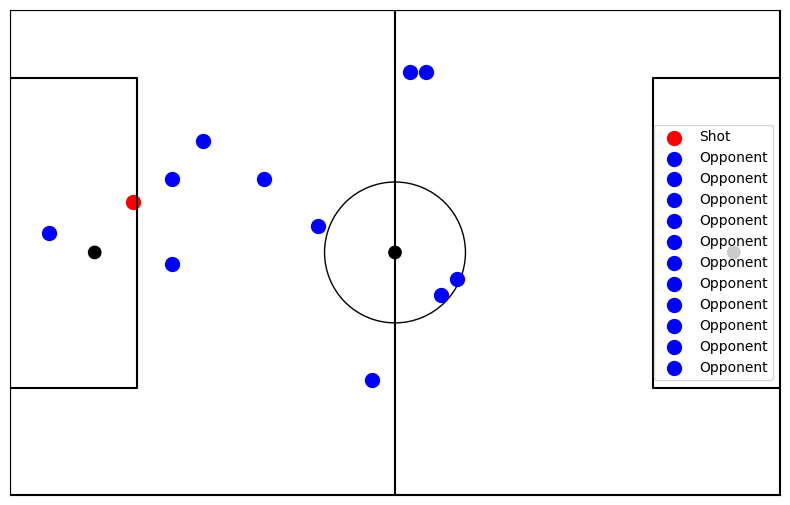

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.00033799]
66


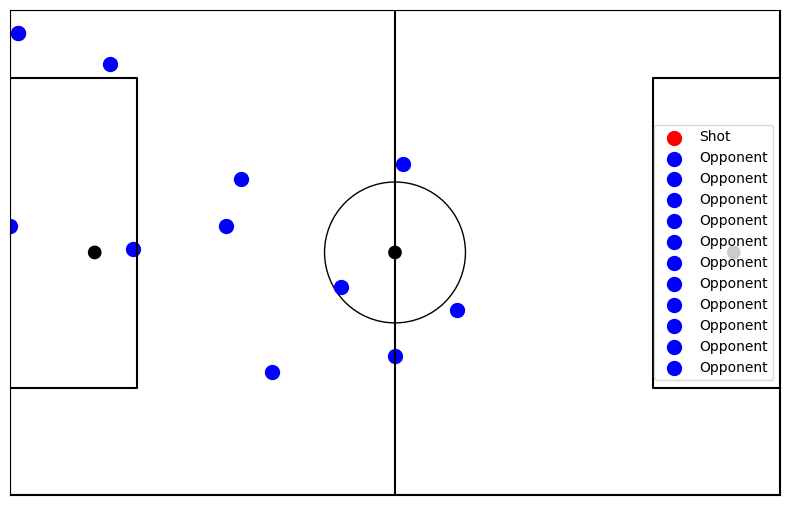

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.00026703]
71


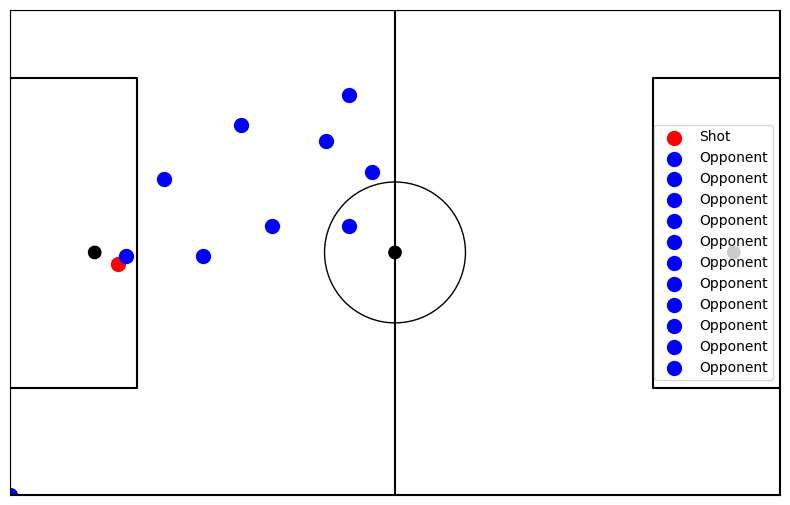

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.0221503]
73


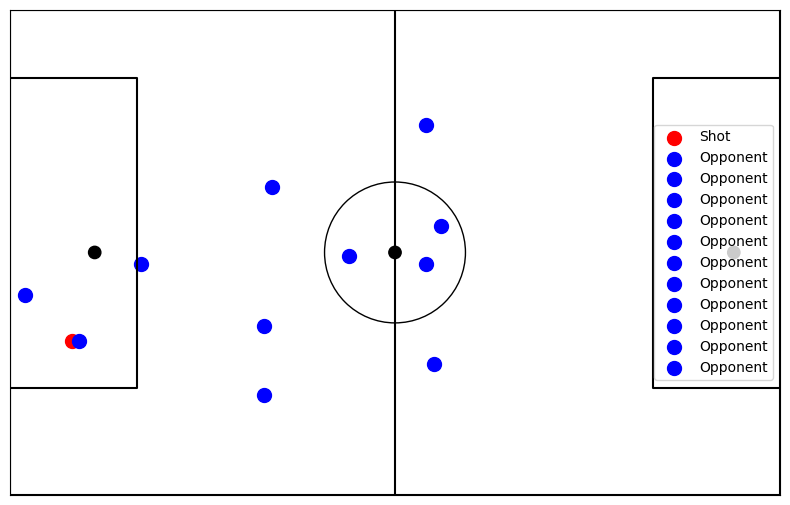

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.02413664]
98


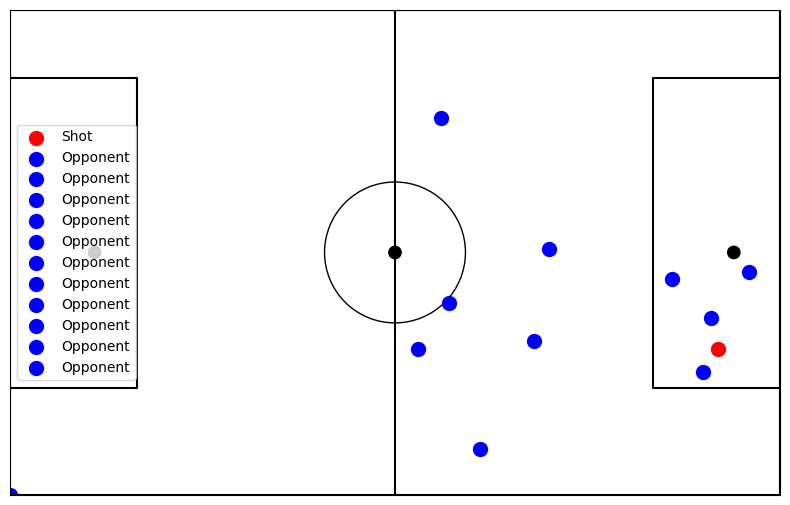

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[0.00030246]
100


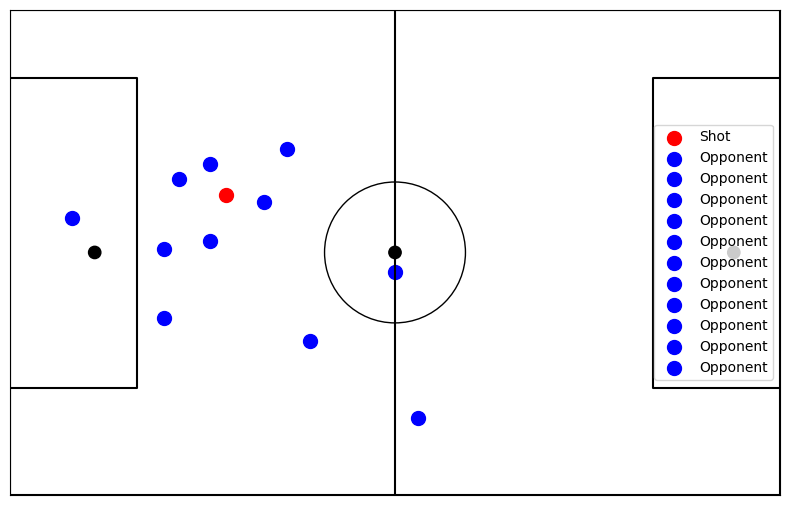

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[0.03287293]
107


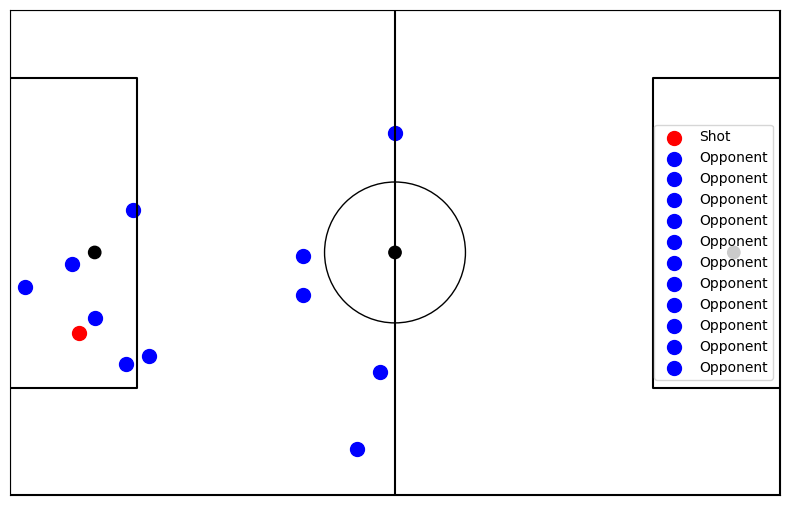

True Label: 1
Predicted Label: [0]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[2.6569985e-05]
108


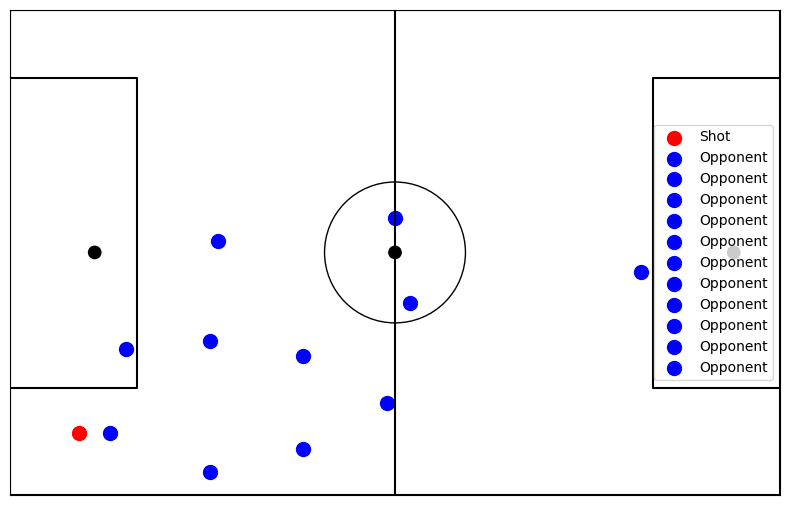

In [247]:
misclassified_indices = np.where(y_pred != y_test)[0]

index = 12

for i in range(len(y_test)):
    if y_test[i] == 1 and y_pred[i] == 0:

        print(f"True Label: {y_test[i]}")
        print(f"Predicted Label: {y_pred[i]}")
        last_sample = X_test[i][-1]  # This gets the last row in the 2D array
        y_prob = model.predict(X_test)
        print(y_prob[i])
        print(i)

        def draw_pitch():
            fig, ax = plt.subplots(figsize=(10, 6.3))
            
            plt.plot([0, 0, 100, 100, 0], [0, 63, 63, 0, 0], color="black")
            plt.plot([50, 50], [0, 63], color="black")
            plt.plot([0, 16.5, 16.5, 0], [13.84, 13.84, 54.16, 54.16], color="black")
            plt.plot([100, 83.5, 83.5, 100], [13.84, 13.84, 54.16, 54.16], color="black") 
            
            centre_circle = plt.Circle((50, 31.5), 9.15, color="black", fill=False)  # Center circle at x=50
            ax.add_patch(centre_circle)
            centre_spot = plt.Circle((50, 31.5), 0.8, color="black")
            ax.add_patch(centre_spot)

            left_pen_spot = plt.Circle((11, 31.5), 0.8, color="black")
            ax.add_patch(left_pen_spot)
            right_pen_spot = plt.Circle((94, 31.5), 0.8, color="black")
            ax.add_patch(right_pen_spot)
            
            ax.set_xlim(0, 100)
            ax.set_ylim(0, 63)
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')

            return fig, ax

        labels = ['shot_x', 'shot_y', 'distance', 'angle',  
                'average_opponent_distance', 'opponents_in_trajectory', 
                'oppx1', 'oppx2', 'oppx3', 'oppx4', 'oppx5', 'oppx6', 'oppx7', 
                'oppx8', 'oppx9', 'oppx10', 'oppx11', 'oppy1', 'oppy2', 'oppy3', 
                'oppy4', 'oppy5', 'oppy6', 'oppy7', 'oppy8', 'oppy9', 'oppy10', 'oppy11']

        # Create a pandas DataFrame
        filled_data = pd.DataFrame([last_sample], columns=labels)

        fig, ax = draw_pitch()

        ax.scatter(filled_data['shot_x'], filled_data['shot_y'], color='red', label='Shot', s=100, marker='o')

        for i in range(1, 12):
                ax.scatter(filled_data[f'oppx{i}'], filled_data[f'oppy{i}'], color='blue', label='Opponent', s=100, marker='o')

        ax.set_xlim([0, 100])
        ax.set_ylim([0, 63])

        plt.legend()

        plt.show()